In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # to ignore some warnings from the allen sdk

import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
from typing import List, Any

from sparks.data.allen.movies_multisess import make_allen_movies_dataset
from sparks.data.misc import LongCycler
from sparks.utils.test import test_on_batch
from sparks.utils.train import train_on_batch
from sparks.data.providers import AllenMoviesTargetProvider
from sparks.models.sparks import SPARKS
from sparks.models.dataclasses import HebbianAttentionConfig, AttentionConfig

# Multi-session training on the Allen visual dataset 

SPARKS allows to train a single model to embed recordings from multiple sessions and animals within the same latent space. <br>

This notebook relies on the `allensdk`, which has incompatibility issues with recent python distributions. Because of this, we've chosen to remove it from the required dependencies of this library. <br>
The easiest way to install this sdk is to: <br>
- clone the GitHub repo from `https://github.com/AllenInstitute/AllenSDK/tree/master`
- edit the `requirements.txt` file at the root of the project to remove all versions requirements
- for numpy only, change the requirements to `numpy<2`
- install from source (from the command line, `cd AllenSDK && pip install -e .`)

Let's start by loading the data in the form of lists of train/test datasets and corresponding Pytorch dataloaders. <br>
This assume you've already downloaded the Allen visual data. 

In [ ]:
path_to_data = os.path.join("/path/to/allen_visual/")

(train_datasets, test_datasets,
    train_dls, test_dls) = make_allen_movies_dataset(path_to_data,
                                                    session_idxs=np.arange(2), # which sessions to load, indexed from 0
                                                    dt=0.01, # time bin size (in seconds), speeds up training at the cost of accuracy for the demo
                                                    batch_size=10,
                                                    mode='prediction', # frame ID prediction
                                                    )

## Initialise model

In [ ]:
embed_dim = 128  # attention embedding dimension
latent_dim = 64  # latent dimension
tau_s = 1.  # STDP decay period (in seconds)
tau_p = 5  # past time-steps window
tau_f = 1  # future time-steps window
n_layers = 0  # number of conventional attention layers
n_heads = 1  # number of attention heads
beta = 1e-6  # KDL regularisation strength

# if a gpu is available
if torch.cuda.is_available():
    device = torch.device('cuda')
# If on a recent macbook
elif torch.backends.mps.is_available():
    device = torch.device('mps:0')
else:
    device = torch.device('cpu')

input_sizes = [len(train_dataset.good_units_ids) for train_dataset in train_datasets]
output_size = 900

hebbian_config = HebbianAttentionConfig(tau_s=tau_s, dt=0.01) # Hebbian attention config
attention_config = AttentionConfig() # conventional attention config
model = SPARKS(n_neurons_per_session=input_sizes,
               embed_dim=embed_dim,
               latent_dim=latent_dim,
               tau_p=tau_p,
               tau_f=tau_f,
               hebbian_config=hebbian_config,
               attention_config=attention_config,
               output_dim_per_session=output_size,
               joint_decoder=True, # use a single decoder for all sessions
               device=device)

lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
loss_fn = torch.nn.CrossEntropyLoss()

## Training and testing

Below, we implement helper functions for the train/test loops with the Allen visual dataset - these exist because memory requirements for reconstruction of the frames are very heavy and frames are loaded on-the-fly. 

In [4]:
def train(sparks: SPARKS,
          train_dls: List,
          loss_fn: Any,
          optimizer: torch.optim.Optimizer,
          beta: float = 0.,
          dt=0.01,
          **kwargs):
    """
    Trains the model on a batch of inputs.

    Args:
        sparks (SPARKS): The SPARKS model instance.
        train_dls (List): List of Dataloaders to train on, typically one per session.
        loss_fn (Any): The loss function used to evaluate the model's predictions.
        optimizer (torch.optim.Optimizer): The optimizer algorithm used to update the model's parameters.
        latent_dim (int): The dimensionality of the latent space.
        tau_p (int): The size of the past window for the model to consider.
        tau_f (int): The size of the future window for the model to predict.
        beta (float, optional): The regularization strength of the Kullback–Leibler divergence in the loss function.
                                Default is 0.
        device (torch.device, optional): The device where the tensors will be allocated. Default is 'cpu'.
        **kwargs: Additional keyword arguments.

        Optional arguments include:
            - session_ids (np.ndarray): Array of session identifiers when training with multiple sessions. Default: np.arange(len(train_dls)).
            - online (bool): If True, updates the model parameters at every time-step. Default is False.
            - burnin (int): The number of initial steps to exclude from training. Default is 0.

    Returns:
        None. The model parameters are updated inline.
    """

    session_ids = kwargs.get('session_ids', np.arange(len(train_dls)))
    random_order = np.random.choice(np.arange(len(train_dls)), size=len(train_dls), replace=False)
    train_iterator = LongCycler([train_dls[i] for i in random_order])

    for i, (inputs, _) in enumerate(train_iterator):
        target_provider = AllenMoviesTargetProvider(frames=None,
                                                    mode='prediction',
                                                    dt=dt)
        train_on_batch(sparks=sparks,
                       inputs=inputs,
                       target_provider=target_provider,
                       loss_fn=loss_fn,
                       optimizer=optimizer,
                       beta=beta,
                       session_id=session_ids[random_order[i % len(train_dls)]],
                       **kwargs)


@torch.no_grad()
def test(sparks: SPARKS,
         test_dls: List,
         loss_fn: Any = None,
         device: torch.device = 'cpu',
         dt=0.01,
         **kwargs):
    """
    Tests the model on a dataset represented by a dataloader and computes the loss.

    Args:
        sparks (SPARKS): The SPARKS model instance.
        test_dls  (List[torch.utils.data.DataLoader]): Dataloaders for the testing data.
        latent_dim (int): The dimensionality of the latent space.
        tau_p (int): The size of the past window for the model to consider.
        tau_f (int, optional): The size of the future window for the model to predict. Default is 1.
        loss_fn (Any, optional): The loss function used to evaluate the model's predictions. Default is None.
        device (torch.device, optional): The device where the tensors will be allocated. Default is 'cpu'.
        **kwargs (dict, optional): Additional keyword arguments for advanced configurations.

        Optional arguments include:
            - session_ids (np.ndarray): Array of session identifiers when training with multiple sessions. Default: np.arange(len(test_dls)).
            - online (bool): If True, updates the model parameters at every time-step. Default is False.
            - burnin (int): The number of initial steps to exclude from training. Default is 0.
            - act (callable): Activation function to apply to the decoder outputs. Default is identity.

    Returns:
        test_loss (float): The computed loss for the test dataset.
        encoder_outputs (torch.tensor): The outputs from the encoder.
        decoder_outputs (torch.tensor): The outputs from the decoder.
    """

    encoder_outputs = torch.Tensor()
    decoder_outputs = torch.Tensor()
    test_loss = 0

    session_ids = kwargs.get('session_ids', np.arange(len(test_dls)))
    
    target_provider = AllenMoviesTargetProvider(frames=None, mode='prediction', dt=dt)

    for i, test_dl in enumerate(test_dls):
        test_iterator = iter(test_dl)
        for inputs, _ in test_iterator:
            test_loss, encoder_outputs_batch, decoder_outputs_batch = test_on_batch(sparks=sparks,
                                                                                    inputs=inputs,
                                                                                    target_provider=target_provider,
                                                                                    test_loss=test_loss,
                                                                                    loss_fn=loss_fn,
                                                                                    device=device,
                                                                                    session_id=session_ids[i],
                                                                                    **kwargs)

            encoder_outputs = torch.cat((encoder_outputs, encoder_outputs_batch), dim=0)
            decoder_outputs = torch.cat((decoder_outputs, decoder_outputs_batch), dim=0)

    test_acc = calculate_test_acc(decoder_outputs, targets=target_provider.targets)

    return test_acc, encoder_outputs, decoder_outputs


@torch.no_grad()
def calculate_test_acc(decoder_outputs: torch.tensor, targets: torch.tensor, tol: int = 30):
    """
    Calculate 1s-test accuracy for the Allen movies datasets
    Args:
        decoder_outputs (torch.tensor): SPARKS predictions.
        frames (torch.tensor): Targets.
        tol (int, optional): Tolerance in number of frames, defaults to 30 (corresponding to 1s).

    Returns:
        test_acc (float): The testing accuracy on this batch.
                          Accuracy is computed as the fraction of time-steps for which the predicted frame was within
                          1s of the correct one.
        encoder_outputs_batch (torch.Tensor): The outputs of the encoder.
        decoder_outputs_batch (torch.Tensor): The outputs of the decoder.
    """

    target_windows = [np.arange(t - tol, t + tol)[None, :] for t in targets.numpy()]
    test_acc = np.mean(np.array([[np.isin(decoder_outputs[k, :, t].cpu().argmax(dim=-1), target_windows[t])
                                  for t in range(decoder_outputs.shape[-1])]
                                 for k in range(decoder_outputs.shape[0])]))

    return test_acc

We can now run the training loop. Note that this will be very slow if not run on a decent GPU.

In [5]:
test_period = 1
n_epochs = 1  # Number of training epochs

pbar = tqdm.tqdm(range(n_epochs))
for epoch in pbar:
    train(sparks=model,
            train_dls=train_dls,
            loss_fn=loss_fn,
            optimizer=optimizer,
            beta=beta,
            device=device)
    scheduler.step()

    if (epoch + 1) % test_period == 0:
        test_acc, encoder_outputs, decoder_outputs = test(sparks=model,
                                                            test_dls=test_dls,
                                                            loss_fn=loss_fn)

        pbar.set_description("Epoch %d, acc: %.3f" % (epoch, test_acc))

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0, acc: 0.077: 100%|██████████| 1/1 [00:15<00:00, 15.85s/it]


After training, a new session can be embedded into the existing latent space by adding a new Hebbian attention head and finetuning the model using the new data.

In [6]:
session_idxs = [2] # new session
(new_train_datasets, new_test_datasets,
    new_train_dls, new_test_dls) = make_allen_movies_dataset(path_to_data,
                                                    session_idxs=session_idxs, # new session
                                                    dt=0.01, # time bin size (in seconds), speeds up training at the cost of accuracy for the demo
                                                    batch_size=10,
                                                    mode='prediction', # frame ID prediction
                                                    )

# Add a new Hebbian attention head for the new session
for i, train_dataset in enumerate(new_train_datasets):
    model.add_session(n_neurons=len(train_dataset.good_units_ids),
                      hebbian_config=hebbian_config,
                      session_id=session_idxs[i]) # session_id allows the model to keep track of which attention head to use for which session

And we can now finetune on the new session

In [7]:
pbar = tqdm.tqdm(range(n_epochs))
for epoch in pbar:
    train(sparks=model,
            train_dls=new_train_dls,
            loss_fn=loss_fn,
            optimizer=optimizer,
            beta=beta,
            session_ids=np.array([2]), # session_ids allows to keep track of the session IDs when training with multiple sessions
            device=device)
    scheduler.step()

    if (epoch + 1) % test_period == 0:
        test_acc, encoder_outputs, decoder_outputs = test(sparks=model,
                                                            test_dls=new_test_dls,
                                                            loss_fn=loss_fn,
                                                            session_ids=np.array([2]))

        pbar.set_description("Epoch %d, acc: %.3f" % (epoch, test_acc))


Epoch 0, acc: 0.074: 100%|██████████| 1/1 [00:07<00:00,  7.59s/it]


# Visualising results

Training on the Allen visual dataset can be quite long, so let us download results from a pre-trained model by running the following cell to visualise the latent embeddings of the sessions.

In [8]:
res_path = os.path.join(os.getcwd(), 'results/allen_results') # path to where the data is located.
# by default where the notebook is located, if the data isn't found it will be downloaded from 
# https://github.com/Iacaruso-lab/sparks-figures/results/allen_results

if not os.path.exists(os.path.join(res_path, 'test_enc_outputs_best.npy')):
    # create the directory
    if not os.path.exists(res_path):
        os.makedirs(res_path)
    # download the data
    import urllib.request
    urllib.request.urlretrieve("https://github.com/Iacaruso-lab/sparks-figures/raw/refs/heads/main/results/allen_results/test_enc_outputs_best.npy",
                               os.path.join(res_path, 'test_enc_outputs_best.npy'))

(-21.309731940428414,
 33.963160971800484,
 -19.133969446023304,
 28.91392817099889,
 -33.36809300879638,
 0.25833320120970416)

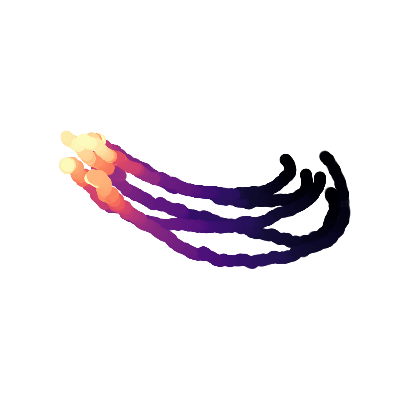

In [9]:
fig = plt.figure(figsize = (12,5))
plt.rcParams['axes.facecolor'] = 'white'

dt = 0.006
time_bin_edges = np.concatenate((np.arange(0, 30., dt), np.array([30.])))
frames_bin_edges = np.concatenate((np.arange(1/30, 30, 1/30), np.array([30.])))
targets = np.array([np.where(time_bin_edges[i] <= frames_bin_edges)[0][0] for i in range(1, len(time_bin_edges))])

tau_p = 6
encs = np.load(os.path.join(res_path, 'test_enc_outputs_best.npy'))[..., tau_p:].transpose(0, 2, 1)

ax1 = plt.subplot(111, projection='3d')

for i in range(5):
    encs_sess = np.mean(encs[i:i+1, :, :], axis=0)
    a = ax1.scatter(encs_sess[:, 0], encs_sess[:, 1], encs_sess[:, 2], cmap = 'magma', c=targets, s=50, label='block 1')
ax1.axis('off')


All the trajectories of the different datasets align in the latent space!

In [10]:
!jupyter nbconvert --to html demo_allen_multisession.ipynb

[NbConvertApp] Converting notebook demo_allen_multisession.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 480407 bytes to demo_allen_multisession.html
